## Arabic Dialect Identification Using a Convolutional Neural Network and AraVec Word Embeddings

**Subtask 1**: Country-level dialect identification: A total of 21,000 tweets, covering all 21 Arab countries. 

In [1]:
# imports
import os
import zipfile
import urllib.request
import requests
import gensim
import itertools
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import math
import re, gc
import tensorflow as tf
SEED = 2018
np.random.seed(SEED)
#tf.set_random_seed(SEED)
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Dense, Flatten, Embedding
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate


import matplotlib.pyplot as plt
import seaborn as sn

Using TensorFlow backend.


## Section 1: Reading the data

This section reads in the **training, development and testing data**. It cleans the data from urls, numbers, names with @, hashtags ..etc. It renames the tweets columns as follows: **train_X - dev_X - test_X**. 

In [2]:
# read the data
def read_files(path):
    file = pd.read_csv(path, sep='\t')
    print ('The shape of the data: ', file.shape)
    return file

In [3]:
train_df = read_files('../../data/train_labeled.tsv')
dev_df = read_files('../../data/dev_labeled.tsv')
test_df = read_files('../../data/test_unlabeled.tsv')

The shape of the data:  (21000, 4)
The shape of the data:  (4957, 4)
The shape of the data:  (5000, 2)


In [4]:
train_df['#3 country_label'].count()

21000

In [5]:
train_df['#3 country_label'].value_counts()

Egypt                   4473
Iraq                    2556
Saudi_Arabia            2312
Algeria                 1491
Oman                    1098
United_Arab_Emirates    1070
Morocco                 1070
Libya                   1070
Syria                   1070
Yemen                    851
Tunisia                  750
Lebanon                  639
Jordan                   426
Kuwait                   420
Palestine                420
Qatar                    234
Djibouti                 210
Mauritania               210
Bahrain                  210
Somalia                  210
Sudan                    210
Name: #3 country_label, dtype: int64

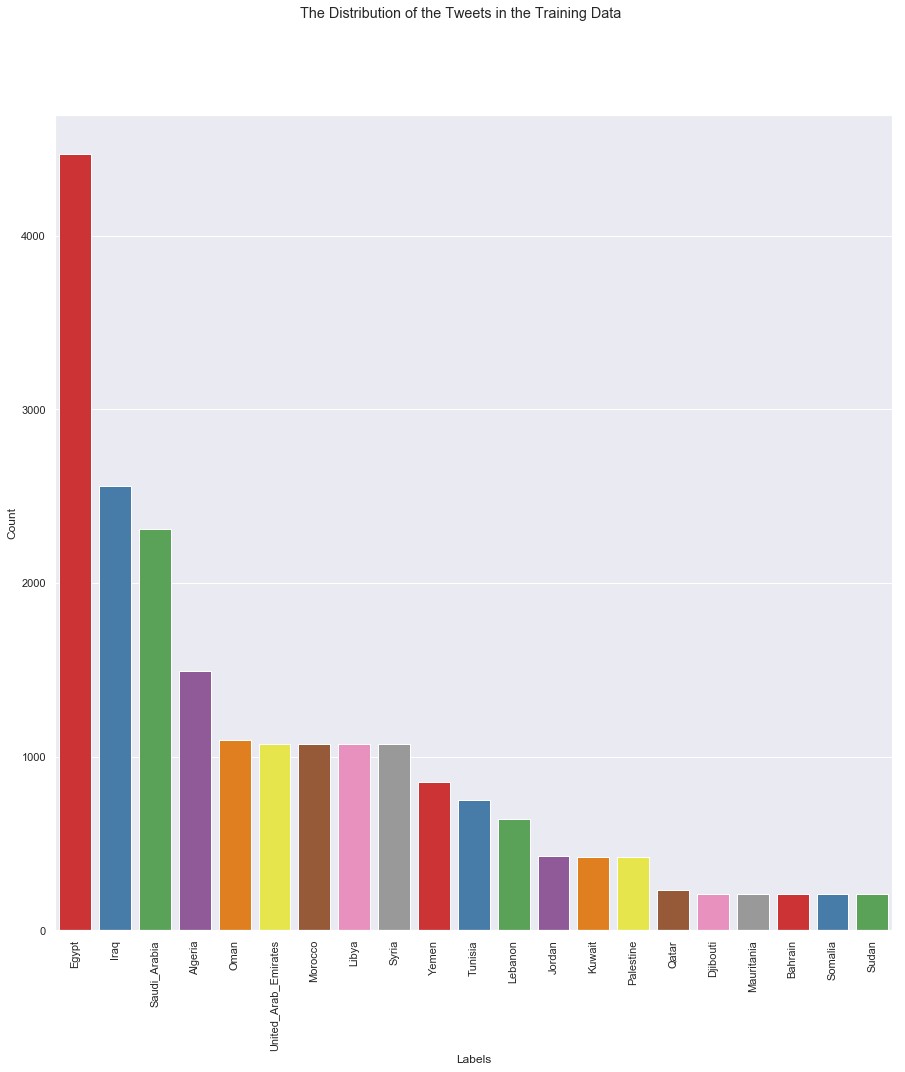

In [6]:
# plot summary of the training data
sn.set(style="darkgrid")
sn.set(font_scale = 1)
train = sn.countplot(x=train_df['#3 country_label'],data=train_df, palette="Set1", 
                 order = train_df['#3 country_label'].value_counts().index)
train.set(xlabel='Labels', ylabel='Count')
for item in train.get_xticklabels():
    item.set_rotation(90)
train.figure.set_size_inches(15, 15)
train.figure.suptitle('The Distribution of the Tweets in the Training Data')
train.figure.savefig("../../figures/training_data_summary")

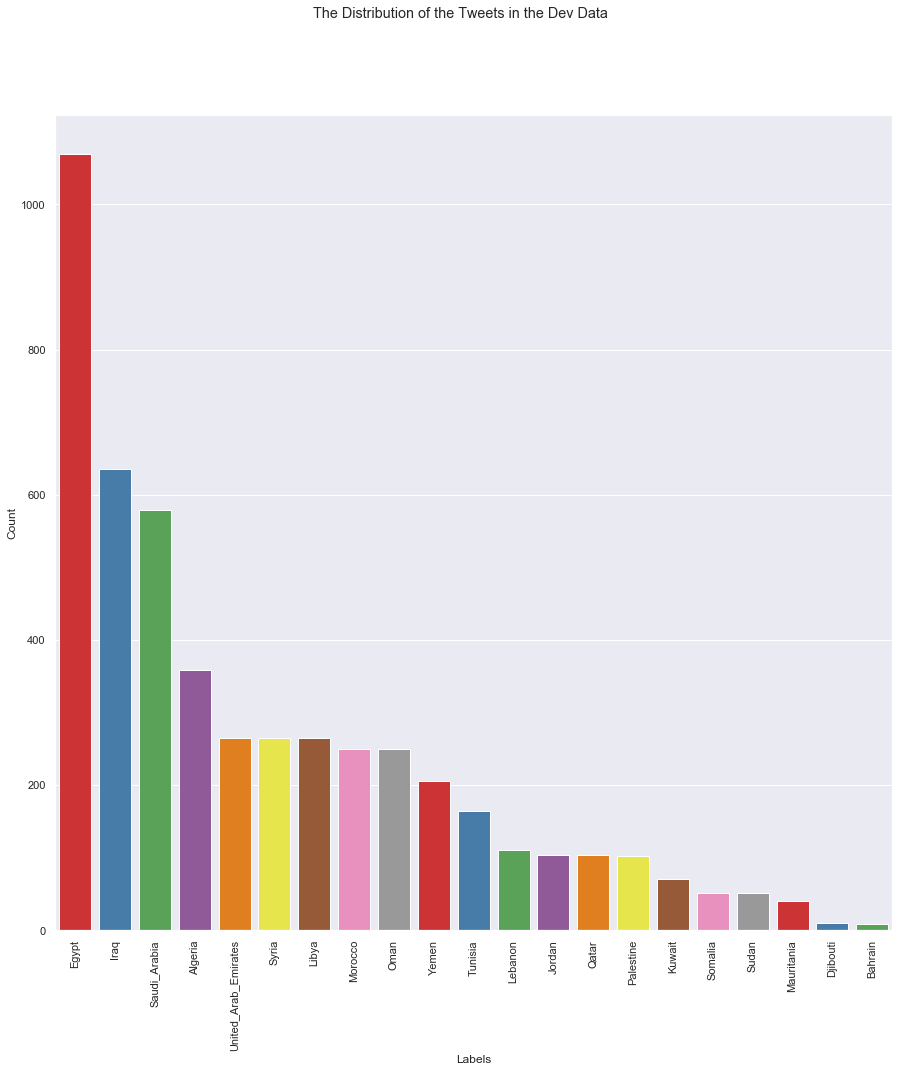

In [7]:
# plot summary of the dev data
sn.set(style="darkgrid")
sn.set(font_scale = 1)
dev = sn.countplot(x=dev_df['#3 country_label'],data=dev_df, palette="Set1", 
                 order = dev_df['#3 country_label'].value_counts().index)
dev.set(xlabel='Labels', ylabel='Count')
for item in dev.get_xticklabels():
    item.set_rotation(90)
dev.figure.set_size_inches(15, 15)
dev.figure.suptitle('The Distribution of the Tweets in the Dev Data')
dev.figure.savefig("../../figures/dev_data_summary")

In [8]:
# clean the data
def normalize(text):
    normalized = str(text)
    normalized = re.sub('http\S+','',normalized) # remove links
    normalized = re.sub('(@[A-Za-z0-9]+)_[A-Za-z0-9]+','',normalized) # remove @names with underscore
    normalized = re.sub('(@[A-Za-z0-9]+)','',normalized) # remove @names
    normalized = re.sub('pic\S+','',normalized) # remove pic.twitter.com links
    normalized = re.sub('\d+','',normalized) # remove numbers
    normalized = re.sub('/b[a-zA-Z0-9]+/b','',normalized) # remove English words 
    return normalized

In [9]:
train_df['#2 tweet_content'] = train_df['#2 tweet_content'].progress_apply(lambda text: normalize(text))
dev_df['#2 tweet_content'] = dev_df['#2 tweet_content'].progress_apply(lambda text: normalize(text))
test_df['#2 tweet_content'] = test_df['#2 tweet_content'].progress_apply(lambda text: normalize(text))

100%|██████████| 5000/5000 [00:00<00:00, 94784.82it/s]


In [10]:
# train X, val X, test X
train_X = train_df["#2 tweet_content"]
dev_X = dev_df["#2 tweet_content"]
test_X = test_df["#2 tweet_content"]

# target values
train_y = train_df['#3 country_label']
#print (train_y)
dev_y = dev_df['#3 country_label']
#print (dev_y)

In [11]:
# skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)
# fold = 0
# for train, dev in skfold.split(train_X, train_y):
#     fold += 1
#     print (f"Fold #{fold}")
    
# train_X = train_X[train]
# train_y = train_y[train]
# dev_X = dev_X[dev]
# dev_y = dev_y[dev]

## Section 2: Tokenizing and padding the data

In [12]:
# Some varialbles to preprocess the data with keras
# 1) embed_size: the length of each word vector
embed_size = 300
# 2) features: unique words to use
max_features = 50000
# 3) maxlen: max number of words to use
maxlen = 100

In [13]:
#fill up the missing values
train_X = train_df["#2 tweet_content"].fillna("_na_").values
dev_X = dev_df["#2 tweet_content"].fillna("_na_").values
test_X = test_df["#2 tweet_content"].fillna("_na_").values

train_y = train_df["#3 country_label"].fillna("_na_").values
dev_y = dev_df["#3 country_label"].fillna("_na_").values

In [14]:
# tokenize the tweets
tokenizer = Tokenizer(num_words=max_features)
#print (tokenizer)
tokenizer.fit_on_texts(list(train_X))

In [15]:
#produce a list of lists- each list is a integer representation of each word in the sentence
train_X = tokenizer.texts_to_sequences(train_X)
#print (train_X)
dev_X = tokenizer.texts_to_sequences(dev_X)
#print (dev_X)
test_X = tokenizer.texts_to_sequences(test_X)
#print (test_X)

In [16]:
# padding the data
train_X = pad_sequences(train_X, maxlen=maxlen)
#print (train_X)
dev_X = pad_sequences(dev_X, maxlen=maxlen)
#print (dev_X)
test_X = pad_sequences(test_X, maxlen=maxlen)
# print (text_X)

## Section 3: Encoding Target Values

In [17]:
# encode target values (labels)
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder()

train_y = label_encoder.fit_transform(train_y)
train_y= train_y.reshape(-1, 1)
train_y = onehot_encoder.fit_transform(train_y)

dev_y = label_encoder.fit_transform(dev_y)
dev_y  = dev_y.reshape(-1 ,1)
dev_y = onehot_encoder.fit_transform(dev_y)

## Section 4: The AraVec Word Embeddings

In [ ]:
# Download the AraVec from the web to the aravec directory
print('Please wait ... Downloading AraVec ... It may take 5 to 7 minutes')
url = 'https://bakrianoo.sfo2.digitaloceanspaces.com/aravec/full_grams_cbow_300_twitter.zip'
urllib.request.urlretrieve(url, '../../aravec/aravec.zip')

In [ ]:
# unzip the AraVec in the same directory
print('Please wait ... unzipping the file')
with zipfile.ZipFile('../../aravec/aravec.zip', 'r') as zipped:
    zipped.extractall('../../aravec/')

In [19]:
# load the AraVec model for Arabic word embeddings - twitter-CBOW (300 vector size)
print ('please wait ... loading the AraVec')
aravec_model = gensim.models.Word2Vec.load('../../aravec/full_grams_cbow_300_twitter.mdl')
print (aravec_model)
my_dict = {}
for index, key in enumerate(aravec_model.wv.vocab):
    my_dict[key] = aravec_model.wv[key]
    
# print the first 2 words and their vectors    
# N = 2
# out = dict(itertools.islice(my_dict.items(), N))
# print (out)

please wait ... loading the AraVec
Word2Vec(vocab=1476715, size=300, alpha=0.025)


In [20]:
# get necessary information from the word embedding model
all_embs = np.stack(my_dict.values())
emb_mean = all_embs.mean()
emb_std = all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
print('The number of words: ',nb_words)

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = my_dict.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

The number of words:  50000


## Section 5: The CNN Model

In [21]:
# the cnn model
def cnn(length=maxlen, vocab_size=max_features):
    # channel 1
    inputs1 = Input(shape=(length,))
    # change input dimensions into fixed size of dense vector
    embedding1 = Embedding(vocab_size, embed_size,weights=[embedding_matrix])(inputs1)
    # conv 1 Dimension 
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    # dropout (to avoid overfitting)
    drop1 = Dropout(0.8)(conv1)
    # 1000 vector, take the maximum 500
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    # tensor into vector
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, embed_size,weights=[embedding_matrix])(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.8)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, embed_size,weights=[embedding_matrix])(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.8)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3]) # parallel
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(21, activation='softmax')(dense1) # sigmoid
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    model.summary()
    return model

model = cnn(maxlen, max_features)
print (model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     15000000    input_1[0][0]                    
____________________________________________________________________________________________

## Section 6: Training, Validating and Testing 

### Subsection 1: Training

In [22]:
train = model.fit([train_X,train_X,train_X], 
                  train_y, 
                  batch_size=50, 
                  epochs=20,
                  validation_data=([dev_X,dev_X,dev_X], dev_y),
                  verbose=2)

/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting spars

Train on 21000 samples, validate on 4957 samples
Epoch 1/20
 - 244s - loss: 2.6353 - accuracy: 0.2242 - val_loss: 2.6062 - val_accuracy: 0.2629
Epoch 2/20
 - 242s - loss: 2.5121 - accuracy: 0.2602 - val_loss: 2.5061 - val_accuracy: 0.2691
Epoch 3/20
 - 243s - loss: 2.4424 - accuracy: 0.2805 - val_loss: 2.4578 - val_accuracy: 0.2937
Epoch 4/20
 - 243s - loss: 2.3686 - accuracy: 0.3026 - val_loss: 2.4829 - val_accuracy: 0.2980
Epoch 5/20
 - 245s - loss: 2.2894 - accuracy: 0.3263 - val_loss: 2.4408 - val_accuracy: 0.3034
Epoch 6/20
 - 241s - loss: 2.2104 - accuracy: 0.3502 - val_loss: 2.3877 - val_accuracy: 0.3087
Epoch 7/20
 - 242s - loss: 2.1310 - accuracy: 0.3687 - val_loss: 2.3824 - val_accuracy: 0.3185
Epoch 8/20
 - 241s - loss: 2.0452 - accuracy: 0.3886 - val_loss: 2.3561 - val_accuracy: 0.3109
Epoch 9/20
 - 242s - loss: 1.9587 - accuracy: 0.4113 - val_loss: 2.3704 - val_accuracy: 0.3177
Epoch 10/20
 - 254s - loss: 1.8616 - accuracy: 0.4380 - val_loss: 2.3726 - val_accuracy: 0.3133


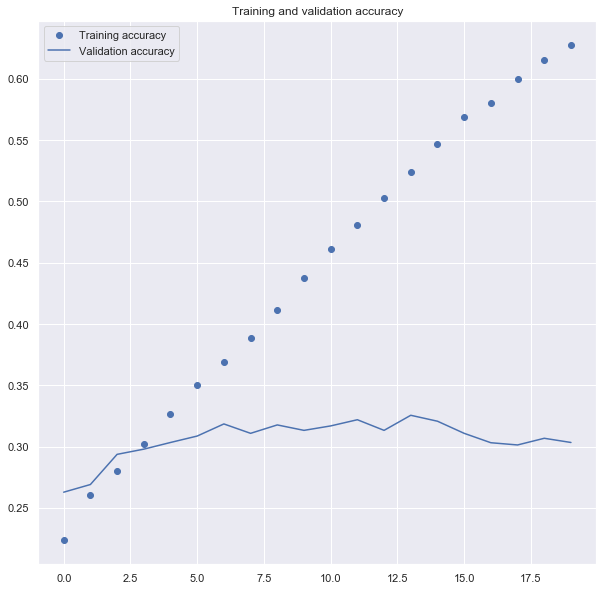

In [23]:
# plotting training accuracy and validation accuracy
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(10,10))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.figure()
plt.savefig('../../figures/train_val_acc.png')

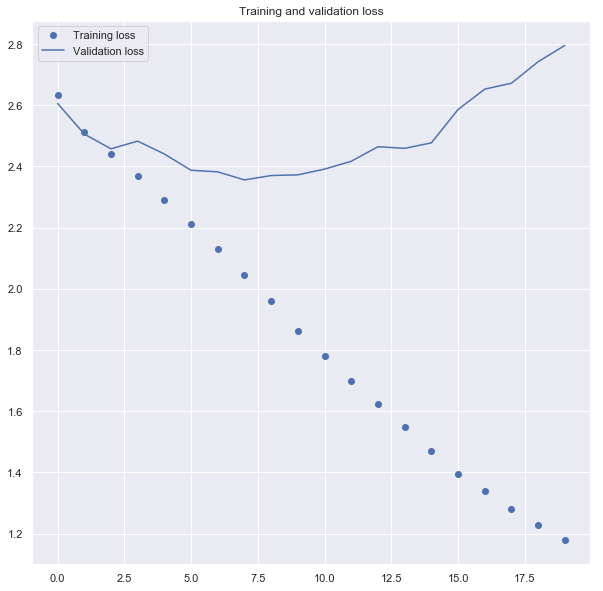

In [24]:
# plotting training loss and validation loss
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('../../figures/train_val_loss.png')
plt.show()

### Subsection 2: Validation

In [36]:
#apply to validation set
pred_dev_y = model.predict([dev_X,dev_X,dev_X], batch_size=50, verbose=1)
indexes = np.argsort(pred_dev_y)[::-1]

4957/4957 [==============================] - 1s 261us/step


In [37]:
# labels for the predicted dev data
labels = np.argmax(pred_dev_y, axis=-1)    
print('Labels are: ',labels)

# getting the labels throw (inverse_transform)
dev_y_predicted = label_encoder.inverse_transform(labels)
print ('The length of predicted labels is: ', len(dev_y_predicted))

# save labels to txt file
with open("../../output/predicted_dev_labels.txt", "w") as f:
    for s in dev_y_predicted:
        f.write(str(s) +"\n")

Labels are:  [ 0  3  0 ...  3  3 14]
The length of predicted labels is:  4957


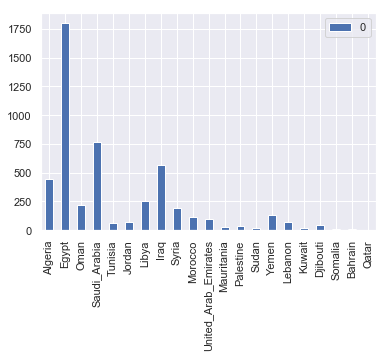

In [38]:
# plotting the results of the validation
counts = Counter(dev_y_predicted)
df = pd.DataFrame.from_dict(counts, orient='index')
df.plot(kind='bar')
plt.savefig('../../figures/predicted_dev_labels.png')

### Subsection 3: Testing

In [41]:
# applying to testing unlabeled dataset
pred_test_y = model.predict([test_X,test_X,test_X], batch_size=50, verbose=1)
pred_test_y
indexes = np.argsort(pred_dev_y)[::-1]
#print (indexes)

# labels for the predicted dev data
labels = np.argmax(pred_test_y, axis=-1)    
#print('Labels are: ',labels)

# getting the labels throw (inverse_transform)
test_y_predicted = label_encoder.inverse_transform(labels)
#print ('The length of predicted labels is: ', len(test_y_predicted))

# save labels to txt file
with open("../../output/predicted_test_labels.txt", "w") as f:
    for s in dev_y_predicted:
        f.write(str(s) +"\n")

5000/5000 [==============================] - 1s 259us/step


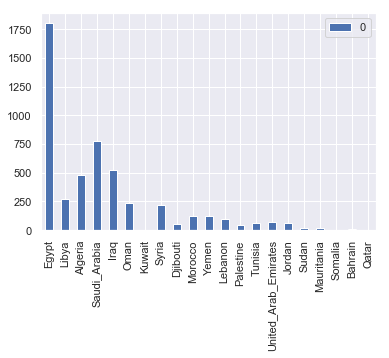

In [42]:
# plotting the results of the validation
counts = Counter(test_y_predicted)
df = pd.DataFrame.from_dict(counts, orient='index')
df.plot(kind='bar')
plt.savefig('../../figures/predicted_test_labels.png')